# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying a zero-ODE-residual on a specified grid.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import controls, ivpsolve, timestep
from probdiffeq.impl import impl
from probdiffeq.util.doc_util import notebook
from probdiffeq.solvers import calibrated, uncalibrated, solution, markov
from probdiffeq.solvers.taylor import autodiff
from probdiffeq.solvers.strategies import (
    filters,
    smoothers,
    fixedpoint,
    priors,
    correction,
)

from tueplots import bundles
import tqdm

/home/kraemer/Projects/probdiffeq-project/probdiffeq/probdiffeq/ivpsolve.py:16: UserWarning: TODO: make adaptive_solver and initial_condition arguments to the solver! Then, fix the notebooks for good, and merge into main ASAP
  warnings.warn(


In [2]:
plt.rcParams.update(notebook.plot_config())
plt.rcParams.update(bundles.neurips2022(nrows=1, ncols=3, family="sans-serif"))

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)

# Make a solver
impl.select("dense", ode_shape=(1,))

In [13]:
# f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vector_field(y, t):
    return 10.0 * y * (2.0 - y)


t0, t1 = 0.0, 0.5
u0 = jnp.asarray([0.1])

In [14]:
NUM_DERIVATIVES = 2
ts = jnp.linspace(t0, t1, num=200, endpoint=True)
init_raw, transitions = priors.ibm_discretised(
    ts, num_derivatives=NUM_DERIVATIVES, output_scale=100.0
)

markov_seq_prior = markov.MarkovSeq(init_raw, transitions)


tcoeffs = autodiff.taylor_mode(
    lambda y: vector_field(y, t=t0), (u0,), num=NUM_DERIVATIVES
)
init_tcoeffs = impl.ssm_util.normal_from_tcoeffs(
    tcoeffs, num_derivatives=NUM_DERIVATIVES
)
markov_seq_tcoeffs = markov.MarkovSeq(init_tcoeffs, transitions)

In [15]:
slr1 = correction.ts1()
ibm = priors.ibm_adaptive(num_derivatives=NUM_DERIVATIVES)
solver = uncalibrated.solver(fixedpoint.fixedpoint_adaptive(ibm, slr1))
dt0 = timestep.propose(lambda y: vector_field(y, t=t0), (u0,))
sol = ivpsolve.solve_and_save_at(
    vector_field,
    tcoeffs,
    save_at=ts,
    rtol=1e-2,
    atol=1e-2,
    dt0=dt0,
    output_scale=1.0,
    solver=solver,
)
# posterior = solution.calibrate(sol.posterior, sol.output_scale)
markov_seq_posterior = markov.select_terminal(sol.posterior)

In [16]:
margs_prior = markov.marginals(markov_seq_prior, reverse=False)
margs_tcoeffs = markov.marginals(markov_seq_tcoeffs, reverse=False)
margs_posterior = markov.marginals(markov_seq_posterior, reverse=True)

In [17]:
num_samples = 10
key = jax.random.PRNGKey(seed=2)
(_qoi, samples_prior), _ = markov.sample(
    key, markov_seq_prior, shape=(num_samples,), reverse=False
)
(_qoi, samples_tcoeffs), _ = markov.sample(
    key, markov_seq_tcoeffs, shape=(num_samples,), reverse=False
)
(_qoi, samples_posterior), _ = markov.sample(
    key, markov_seq_posterior, shape=(num_samples,), reverse=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.93it/s]


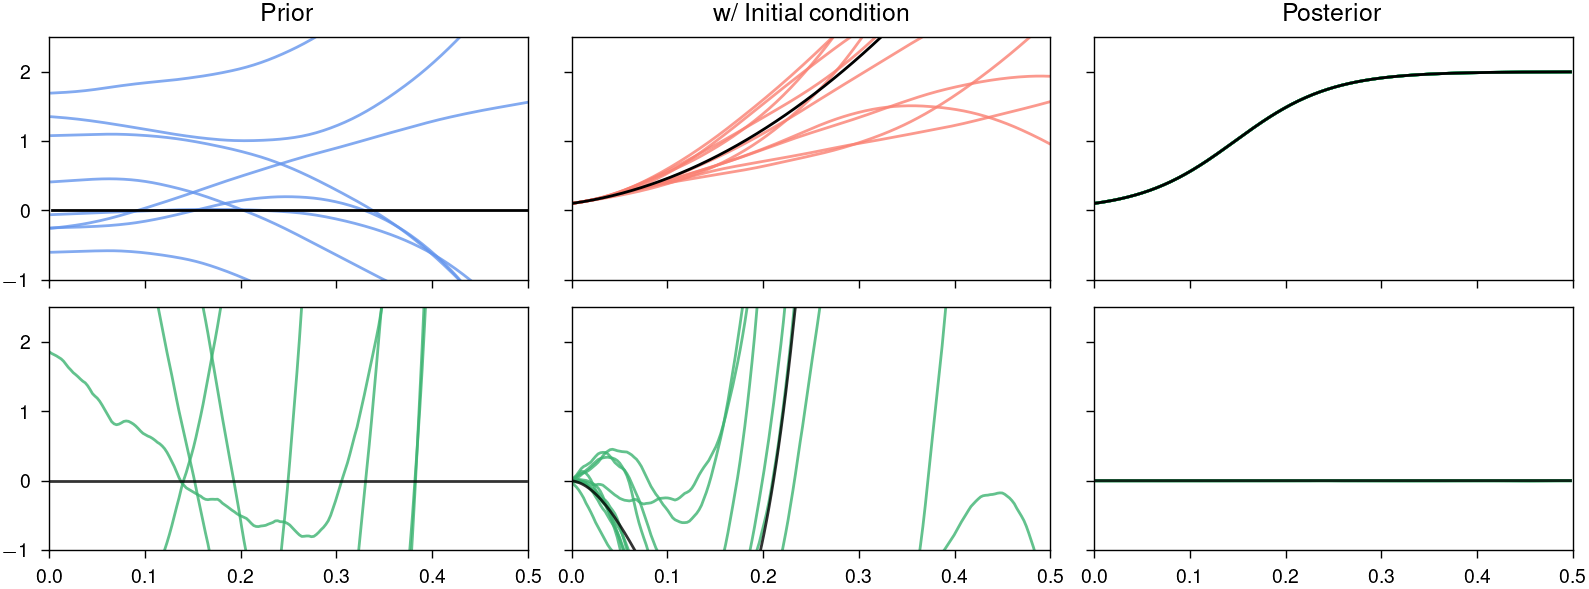

In [18]:
fig, (axes, axes_magnitude) = plt.subplots(
    nrows=2, ncols=3, sharex=True, figsize=(8, 3), sharey=True
)
axes[0].set_title("Prior")
axes[1].set_title("w/ Initial condition")
axes[2].set_title("Posterior")

for i in tqdm.tqdm(range(num_samples)):
    axes[0].plot(ts[1:], samples_prior[i, ..., 0], marker="None", alpha=0.8, color="C0")
    axes[1].plot(
        ts[1:], samples_tcoeffs[i, ..., 0], marker="None", alpha=0.8, color="C1"
    )
    axes[2].plot(
        ts[:-1], samples_posterior[i, ..., 0], marker="None", alpha=0.8, color="C2"
    )

    axes_magnitude[0].plot(
        ts[:-1],
        samples_prior[i, ..., 1]
        - jax.vmap(vector_field)(samples_prior[i, ..., 0], ts[:-1]),
        marker="None",
        alpha=0.8,
        color="C2",
    )
    axes_magnitude[1].plot(
        ts[:-1],
        samples_tcoeffs[i, ..., 1]
        - jax.vmap(vector_field)(samples_tcoeffs[i, ..., 0], ts[:-1]),
        marker="None",
        alpha=0.8,
        color="C2",
    )
    axes_magnitude[2].plot(
        ts[:-1],
        samples_posterior[i, ..., 1]
        - jax.vmap(vector_field)(samples_posterior[i, ..., 0], ts[:-1]),
        marker="None",
        alpha=0.8,
        color="C2",
    )


axes[0].plot(ts[1:], margs_prior.mean[..., 0], color="black", marker="None")
axes[1].plot(ts[1:], margs_tcoeffs.mean[..., 0], color="black", marker="None")
axes[2].plot(ts[:-1], margs_posterior.mean[..., 0], color="black", marker="None")

axes_magnitude[0].plot(
    ts[:-1],
    margs_prior.mean[..., 1]
    - jax.vmap(vector_field)(margs_prior.mean[..., 0], ts[:-1]),
    marker="None",
    alpha=0.8,
    color="black",
)
axes_magnitude[1].plot(
    ts[:-1],
    margs_tcoeffs.mean[..., 1]
    - jax.vmap(vector_field)(margs_tcoeffs.mean[..., 0], ts[:-1]),
    marker="None",
    alpha=0.8,
    color="black",
)
axes_magnitude[2].plot(
    ts[:-1],
    margs_posterior.mean[..., 1]
    - jax.vmap(vector_field)(margs_posterior.mean[..., 0], ts[:-1]),
    marker="None",
    alpha=0.8,
    color="black",
)

axes[0].set_xlim((t0, t1))
axes[0].set_ylim((-1.0, 2.5))


plt.show()

(199, 1) (199, 1, 1)


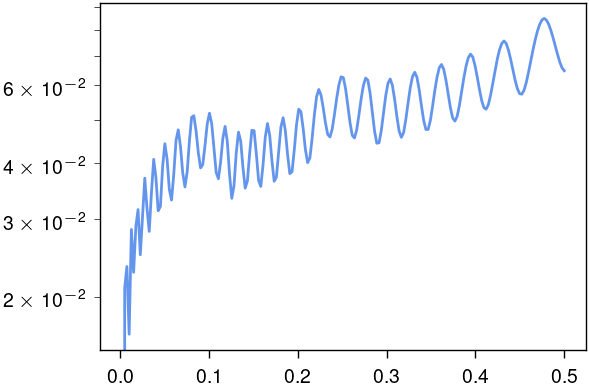

In [19]:
m, s = impl.hidden_model.marginal_nth_derivative(margs_posterior, -1)

plt.subplots(figsize=(3, 2), dpi=200)
print(m.shape, s.shape)
plt.semilogy(ts[1:], jnp.sqrt(s[..., -1, 0].squeeze() ** 2), marker="None")
plt.show()

In [10]:
samples_tcoeffs[..., 0]

Array([[ 0.10227801,  0.10459799,  0.10699059, ..., -0.6265948 ,
        -0.65853103, -0.69103734],
       [ 0.10228496,  0.10462348,  0.10702768, ..., -0.53361922,
        -0.58220049, -0.63159331],
       [ 0.10228724,  0.10468857,  0.10725232, ...,  1.89018551,
         1.91539556,  1.94105487],
       ...,
       [ 0.1022786 ,  0.10458971,  0.10693739, ..., -1.86588283,
        -1.90303483, -1.94072394],
       [ 0.10228544,  0.10465909,  0.10717487, ..., -2.81063556,
        -2.86511409, -2.92006097],
       [ 0.10226609,  0.10451192,  0.10671692, ...,  4.300309  ,
         4.36091328,  4.42188944]], dtype=float64)

In [11]:
sol.num_steps

Array([ 2.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 11., 11.,
       11., 11., 11., 11., 11., 11., 11., 11., 11., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 13., 13., 13., 13.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17

In [12]:
assert False

AssertionError: 

In [ ]:
eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, num=500, endpoint=True)
_, margs_posterior = solution.offgrid_marginals_searchsorted(
    ts=mesh, solution=sol, solver=solver
)

In [ ]:
f_vect = jax.vmap(f)
fig, (ax_sol, ax_res, ax_mag) = plt.subplots(
    ncols=3, nrows=3, sharex=True, sharey="row"
)

sol_raw0 = impl.hidden_model.marginal_nth_derivative(marg_raw, 0)
sol_tcoeffs0 = impl.hidden_model.marginal_nth_derivative(marg_tcoeffs, 0)
sol_full0 = impl.hidden_model.marginal_nth_derivative(marginals, 0)

sol_raw1 = impl.hidden_model.marginal_nth_derivative(marg_raw, 1)
sol_tcoeffs1 = impl.hidden_model.marginal_nth_derivative(marg_tcoeffs, 1)
sol_full1 = impl.hidden_model.marginal_nth_derivative(marginals, 1)

# ax_sol[0].set_title("Prior")
# ax_sol[0].set_xlim((ts[1], ts[-1]))
# for sol_raw in (sol_raw0, sol_raw1):
#     m, s = jnp.squeeze(sol_raw.mean), jnp.abs(jnp.squeeze(sol_raw.cholesky))
#     ax_sol[0].plot(ts[1:], m, marker="None")
#     ax_sol[0].fill_between(ts[1:], m - s,m + s, alpha=0.125)

ax_sol[0].set_title(r"Prior + initial condition")
ax_sol[0].set_xlim((ts[1], ts[-1]))
for sol_tcoeffs in (sol_tcoeffs0, sol_tcoeffs1):
    m, s = jnp.squeeze(sol_tcoeffs.mean), jnp.abs(jnp.squeeze(sol_tcoeffs.cholesky))
    ax_sol[0].plot(ts[1:], m, marker="None")
    ax_sol[0].fill_between(ts[1:], m - s, m + s, alpha=0.125)


ax_sol[1].set_title("Conditional")
ax_sol[1].set_xlim((ts[1], ts[-1]))
for sol_full in (sol_full0, sol_full1):
    m, s = jnp.squeeze(sol_full.mean), jnp.abs(jnp.squeeze(sol_full.cholesky))
    ax_sol[1].plot(mesh, m, marker="None")
    ax_sol[1].fill_between(mesh, m - s, m + s, alpha=0.125)

ax_sol[0].set_ylabel("State, derivative")
ax_res[0].set_ylabel("Residual")


# ax_res[0].semilogy(ts[1:], jnp.abs(sol_raw1.mean - jax.vmap(vector_field)(sol_raw0.mean, ts[1:]))+1e-10, marker="None")
ax_res[0].semilogy(
    ts[1:],
    jnp.abs(sol_tcoeffs1.mean - jax.vmap(vector_field)(sol_tcoeffs0.mean, ts[1:]))
    + 1e-10,
    marker="None",
)
ax_res[1].semilogy(
    mesh,
    jnp.abs(sol_full1.mean - jax.vmap(vector_field)(sol_full0.mean, mesh)) + 1e-10,
    marker="None",
)
ax_res[1].semilogy(
    mesh,
    jnp.abs(sol_full1.mean - jax.vmap(vector_field)(sol_full0.mean, mesh)) + 1e-10,
    marker="None",
)

fig.align_ylabels()
plt.savefig("collocation.pdf")

In [ ]:
assert False

In [ ]:
# Solve the ODE with low precision

In [ ]:
# Evalate the posterior on a dense grid


posterior_u = impl.hidden_model.marginal_nth_derivative(marginals, 0).mean
posterior_du = impl.hidden_model.marginal_nth_derivative(marginals, 1).mean

In [ ]:
# Extrapolate the prior on the dense grid

taylor_coefficients = jnp.reshape(
    sol.marginals.mean[0, ...],
    sol.marginals.target_shape,
    order="F",
)


prior_u = []
prior_du = []
model, _ = filters.filter(*impl)
rv = model.extrapolation.solution_from_tcoeffs(taylor_coefficients)
ssv, extra = model.extrapolation.init(rv)
for t_old, t_new in zip(mesh[:-1], mesh[1:]):
    prior_u.append(rv.marginal_nth_derivative(0).mean)
    prior_du.append(rv.marginal_nth_derivative(1).mean)

    dt = t_new - t_old
    ssv, extra = model.extrapolation.begin(ssv, extra, dt)
    ssv, extra = model.extrapolation.complete(
        ssv, extra, output_scale=sol.output_scale.mean()
    )
    rv = model.extrapolation.extract(ssv, extra)


prior_u.append(rv.marginal_nth_derivative(0).mean)
prior_du.append(rv.marginal_nth_derivative(1).mean)

prior_u = jnp.asarray(prior_u)
prior_du = jnp.asarray(prior_du)

In [ ]:
# Plot the samples

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 3), sharex=True, sharey="row")
((ax0, ax1), (ax2, ax3), (ax4, ax5)) = axes


#######################
ax0.set_ylabel("State")

ax0.set_title("Prior")
ax0.plot(mesh, prior_u, marker="None", label="Estimate")
ax0.plot(
    mesh, posterior_u, marker="None", linestyle="dotted", color="C1", label="Target"
)

ax1.set_title("Posterior")
ax1.plot(mesh, posterior_u, marker="None")
ax1.plot(mesh, posterior_u, marker="None", linestyle="dotted", color="C1")


#######################
ax2.set_ylabel("Residual")

ax2.plot(mesh, prior_du - f_vect(prior_u, *f_args), marker="None")
ax2.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax3.plot(mesh, posterior_du - f_vect(posterior_u, *f_args), marker="None")
ax3.axhline(0.0, linestyle="dotted", color="C1", marker="None")


#######################
ax4.set_ylabel("|| Residual ||")

ax4.semilogy(mesh, jnp.abs(prior_du - f_vect(prior_u, *f_args)), marker="None")
ax5.semilogy(mesh, jnp.abs(posterior_du - f_vect(posterior_u, *f_args)), marker="None")
ax4.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax5.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax4.set_ylim((1e-8, 1e0))
ax5.set_ylim((1e-8, 1e0))


ax0.set_xlim((t0, t1))
ax0.legend()
fig.align_ylabels()
plt.show()

The prior state estimate (top left) has a large residual $\dot u - f(u)$. By conditioning on satisfying a zero residual (bottom left to bottom right), the state estimate becomes a useful ODE solution (top right).